# Определение обсценной лексики

## Загрузки и импорты

In [ ]:
# install Anaconda3
!wget -qO ac.sh https://repo.anaconda.com/archive/Anaconda3-2020.07-Linux-x86_64.sh 
!bash ./ac.sh -b

# a fake google.colab library
!ln -s /usr/local/lib/python3.6/dist-packages/google \
       /root/anaconda3/lib/python3.8/site-packages/google

# start jupyterlab, which now has Python3 = 3.8
!nohup /root/anaconda3/bin/jupyter-lab --ip=0.0.0.0&

# access through ngrok, click the link
!pip install pyngrok -q
from pyngrok import ngrok
print(ngrok.connect(8888))

### Библиотеки

In [ ]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (3.8.3)


In [ ]:
!pip install pymorphy2==0.9.1

### Загрузка предобученной векторной модели FastText Araneum Russicum

In [ ]:
!wget https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz

--2021-03-02 11:11:57--  https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz
Resolving rusvectores.org (rusvectores.org)... 116.203.104.23
Connecting to rusvectores.org (rusvectores.org)|116.203.104.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2691248108 (2.5G) [application/x-gzip]
Saving to: ‘araneum_none_fasttextcbow_300_5_2018.tgz’

araneum_none_fastte 100%[===================>]   2.51G  28.1MB/s    in 94s     

2021-03-02 11:13:32 (27.2 MB/s) - ‘araneum_none_fasttextcbow_300_5_2018.tgz’ saved [2691248108/2691248108]



### Импорты

In [ ]:
import tarfile
import gensim
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, train_test_split
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm
from string import punctuation

tokenizer = nltk.tokenize.WhitespaceTokenizer()
morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
vector_archive_path = "/content/araneum_none_fasttextcbow_300_5_2018.tgz"
vector_model_path = "/content/araneum_none_fasttextcbow_300_5_2018.model"
model_path = "/content/drive/MyDrive/thesis_datasets/obscene_detection.model"
obscene_data_path = "/content/drive/MyDrive/thesis_datasets/obscene_preprocessed_corpus.txt"
not_obscene_data_path = "/content/drive/MyDrive/thesis_datasets/2ch_corpus_preprocessed.txt"
corpus_path = "/content/drive/MyDrive/thesis_datasets/obscene_data.csv"

In [ ]:
fasttext_file = tarfile.open(vector_archive_path, "r")
fasttext_file.extractall()

## Подготовка корпуса слов для обучения

In [ ]:
with open(obscene_data_path, "r") as obscene_data_file:
  obscene_data = obscene_data_file.readlines()

In [ ]:
obscene_data[:20]

['6ля\n',
 '6ляд\n',
 'fuck\n',
 'pizd\n',
 'pizda\n',
 'pizdah\n',
 'pizdakh\n',
 'pizdam\n',
 'pizdami\n',
 'pizdax\n',
 'pizde\n',
 'pizdoi\n',
 'pizdoj\n',
 'pizdoy\n',
 'pizdu\n',
 'pizdy\n',
 'scheise\n',
 'scheisse\n',
 'shit\n',
 'suck\n']

In [ ]:
len(obscene_data)

9832

In [ ]:
with open(not_obscene_data_path, "r") as not_obscene_data_file:
  not_obscene_data = not_obscene_data_file.readlines()

In [ ]:
not_obscene_data[:20]

['приближённый\n',
 'хаскеле-то\n',
 'лье\n',
 'плейофф\n',
 'привязывать\n',
 'атб\n',
 '3128\n',
 'комуфляж\n',
 'голова-туловище\n',
 'чикаго-кун\n',
 'уберняша\n',
 'редактироваться\n',
 'погаснуть\n',
 'ньюфажига\n',
 'лолмимо\n',
 'aodv\n',
 'efkz@yandex\n',
 '60кт\n',
 'military\n',
 'многопользовательский\n']

In [ ]:
len(not_obscene_data)

114660

In [ ]:
def corpus_preprocess(words: list) -> list:
    
    words = [word.strip('\n').strip(punct) for word in words]

    return words

In [ ]:
obscene_data = corpus_preprocess(obscene_data)
obscene_data[:10]

['6ля',
 '6ляд',
 'fuck',
 'pizd',
 'pizda',
 'pizdah',
 'pizdakh',
 'pizdam',
 'pizdami',
 'pizdax']

In [ ]:
not_obscene_data = corpus_preprocess(not_obscene_data)
not_obscene_data[:10]

['приближённый',
 'хаскеле-то',
 'лье',
 'плейофф',
 'привязывать',
 'атб',
 '3128',
 'комуфляж',
 'голова-туловище',
 'чикаго-кун']

In [ ]:
obscene_data = list(set(obscene_data))
not_obscene_data = list(set(not_obscene_data))

In [ ]:
obscene_df = pd.DataFrame(data = obscene_data, columns = ['words'])
not_obscene_df = pd.DataFrame(data = not_obscene_data, columns = ['words'])

In [ ]:
obscene_df['labels'] = [1 for _ in range(len(obscene_df))]
not_obscene_df['labels'] = [0 for _ in range(len(not_obscene_df))]

In [ ]:
obscene_df.head()

,words,labels
0,закакиваться,1
1,переебавший,1
2,объебались,1
3,охобачивать,1
4,умандовать,1


In [ ]:
not_obscene_df.head()

,words,labels
0,т̠̺͉̮͖̼́ы͖ͅ,0
1,фэйсбук,0
2,порой,0
3,близнецы>слишко,0
4,пахи,0


In [ ]:
corpus = pd.concat([obscene_df, not_obscene_df], axis=0)

In [ ]:
corpus.head()

,words,labels
0,закакиваться,1
1,переебавший,1
2,объебались,1
3,охобачивать,1
4,умандовать,1


In [ ]:
len(corpus)

124172

In [ ]:
len(corpus.labels.unique())

2

In [ ]:
corpus.labels.unique()

array([1, 0])

In [ ]:
corpus = corpus.sample(frac=1)

In [ ]:
corpus.head()

,words,labels
16753,мышиный,0
12607,тафак,0
105864,маргиналам,0
83394,зачаровний,0
45612,грэмми,0


In [ ]:
corpus.to_csv(corpus_path)

In [ ]:
len(corpus)

124172

## Бейзлайн

In [ ]:
fasttext = gensim.models.KeyedVectors.load(vector_model_path)

In [ ]:
corpus = pd.read_csv(corpus_path)
corpus.dropna(inplace=True)

In [ ]:
len(corpus)

124171

In [ ]:
def get_embeddings(words: list, vector_model=fasttext):
    vectors = np.zeros((len(words), 300))
    for i, word in enumerate(words):
        vector = vector_model[word]
        vectors[i] = vector
    return vectors

In [ ]:
X = get_embeddings([word for word in corpus.words.values])
y = corpus.labels.values

In [ ]:
X.shape, y.shape

((124171, 300), (124171,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logreg = LogisticRegression().fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     22952
           1       0.67      0.20      0.31      1883

    accuracy                           0.93     24835
   macro avg       0.80      0.60      0.64     24835
weighted avg       0.92      0.93      0.91     24835



In [ ]:
f1_score(y_test, y_pred)

0.30825838103025344

## Эксперимент по нормализации данных

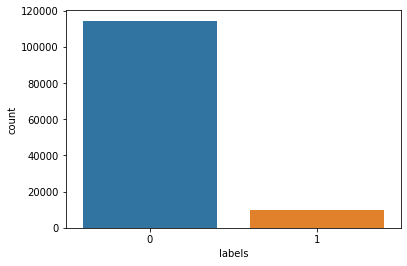

In [ ]:
import seaborn as sns

sns.countplot(x='labels', data=corpus)

In [ ]:
obscene = corpus[corpus.labels == 1]
not_obscene = corpus[corpus.labels == 0]

In [ ]:
len(obscene)

9799

In [ ]:
len(not_obscene)

114372

In [ ]:
not_obscene = not_obscene.sample(13000, random_state=42)

In [ ]:
corpus = pd.concat([obscene, not_obscene]).sample(frac=1)

In [ ]:
corpus.head()

,Unnamed: 0,words,labels
79968,109150,2:58,0
3676,3868,иценко-похуишинг,1
99287,90944,бредача,0
4621,6401,разъебайский,1
52790,26752,задымить,0


In [ ]:
len(corpus)

22799

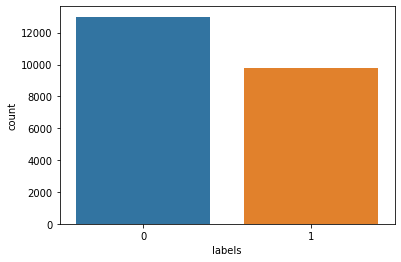

In [ ]:
sns.countplot(x='labels', data=corpus)

In [ ]:
X = get_embeddings(corpus.words.values.tolist())
y = corpus.labels.values

In [ ]:
X.shape, y.shape

((22799, 300), (22799,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
logreg = LogisticRegression().fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2606
           1       0.84      0.73      0.78      1954

    accuracy                           0.82      4560
   macro avg       0.83      0.81      0.82      4560
weighted avg       0.82      0.82      0.82      4560



In [ ]:
f1_score(y_test, y_pred)

0.7792349726775956

## Эксперимент с подбором параметров

In [ ]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
stratified_folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)
repeated_folds = RepeatedStratifiedKFold(n_splits=n_fold, n_repeats=10, random_state=0)

In [ ]:
def make_grid_search(X_train, y_train, model=None, params_grid={'': []}, scoring='', n_jobs=0, folds=folds):
  grid_search = GridSearchCV(model, param_grid=params_grid, cv=folds, scoring=scoring, n_jobs=n_jobs)
  grid_search.fit(X_train, y_train)
  print(f'Best score: {grid_search.best_score_}')
  print(f'Best parameters: {grid_search.best_params_}')
  return grid_search.best_params_

In [ ]:
parameters_logreg = {'class_weight' : ['balanced', None],
                  'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                  'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  'C' : [0.15, 1.0, 10.0, 100.0],
                  'max_iter': [10,50,100]
                 }

In [ ]:
logreg = LogisticRegression(random_state=42)

In [ ]:
%%time
best_params_folds = make_grid_search(X_train, y_train, logreg, parameters_logreg, 'f1_macro', n_jobs=5, folds=folds)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best score: 0.8432978345035046
Best parameters: {'C': 0.15, 'class_weight': 'balanced', 'max_iter': 10, 'penalty': 'none', 'solver': 'saga'}
CPU times: user 12.8 s, sys: 1.14 s, total: 13.9 s
Wall time: 29min 13s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
best_params_folds

{'C': 0.15,
 'class_weight': 'balanced',
 'max_iter': 10,
 'penalty': 'none',
 'solver': 'saga'}

In [ ]:
%%time
best_params_stratified_folds = make_grid_search(X_train, y_train, logreg, parameters_logreg, 'f1_macro', n_jobs=5, folds=stratified_folds)

Best score: 0.8436269059601678
Best parameters: {'C': 100.0, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
CPU times: user 14.1 s, sys: 1.07 s, total: 15.2 s
Wall time: 27min 19s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
best_params_stratified_folds

{'C': 100.0,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [ ]:
%%time
best_params_folds = make_grid_search(X_train, y_train, logreg, parameters_logreg, 'f1_micro', n_jobs=5, folds=folds)

In [ ]:
%%time
best_params_stratified_folds = make_grid_search(X_train, y_train, logreg, parameters_logreg, 'f1_micro', n_jobs=5, folds=stratified_folds)

In [ ]:
%%time
best_params_repeated_folds = make_grid_search(X_train, y_train, logreg, parameters_logreg, 'f1_micro', n_jobs=5, folds=repeated_folds)